## ДЗ №3 Двухуровневый пайплайн
#### В этой домашке вам предстоит написать с нуля двустадийную рекомендательную систему.

#### Дата выдачи: 10.03.25

#### Мягкий дедлайн: 31.03.25 23:59 MSK

#### Жесткий дедлайн: 7.04.25 23:59 MSK

### Описание
Это творческое задание, в котором вам необходимо реализовать полный цикл построения рекомендательной системы: реализовать кандидат генераторов, придумать и собрать признаки, обучить итоговый ранкер и заинференсить модели на всех пользователей.

Вам предоставляется два набора данных: `train.csv` и `test.csv`

In [1]:
# скачиваем данные
# если из этой ячейки не получается, то вот ссылка на папку https://drive.google.com/drive/folders/1HT0Apm8Jft0VPLJtdBBUGu9s1M7vZcoJ?usp=drive_link

!pip3 install gdown


import gdown
# train
url = "https://drive.google.com/file/d/1-CcS22-UpTJeNcFlA0dVLrEQn8jnI0d-/view?usp=drive_link"
output = 'train.csv'
gdown.download(url, output, quiet=False)

# test
url = "https://drive.google.com/file/d/11iz3xDh0IIoEIBY0dyRSvByY3qfiT3BG/view?usp=drive_link"
output = 'test.csv'
gdown.download(url, output, quiet=False)

C:\Users\nikza\AppData\Roaming\Python\Python311\site-packages\gdown\parse_url.py:48: UserWarning: You specified a Google Drive link that is not the correct link to download a file. You might want to try `--fuzzy` option or the following url: https://drive.google.com/uc?id=1-CcS22-UpTJeNcFlA0dVLrEQn8jnI0d-
  warnings.warn(
Downloading...
From: https://drive.google.com/file/d/1-CcS22-UpTJeNcFlA0dVLrEQn8jnI0d-/view?usp=drive_link
To: C:\Users\nikza\Desktop\магистратура\Учёба\homework_AI\Рекомендательные_системы\HW3\train.csv
92.9kB [00:00, 23.2MB/s]
C:\Users\nikza\AppData\Roaming\Python\Python311\site-packages\gdown\parse_url.py:48: UserWarning: You specified a Google Drive link that is not the correct link to download a file. You might want to try `--fuzzy` option or the following url: https://drive.google.com/uc?id=11iz3xDh0IIoEIBY0dyRSvByY3qfiT3BG
  warnings.warn(
Downloading...
From: https://drive.google.com/file/d/11iz3xDh0IIoEIBY0dyRSvByY3qfiT3BG/view?usp=drive_link
To: C:\Users\nik

'test.csv'

In [1]:
!pip install pandas
!pip install shap
!pip install matplotlib
!pip install xgboost

In [6]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import xgboost as xgb
import shap
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix
import time

is_gpu = torch.cuda.is_available()
device = torch.device("cuda" if is_gpu else "cpu")
print("Используем устройство:", device)

Используем устройство: cpu




### 1 Этап. Модели первого уровня. (max 3 балла)
В этом этапе вам необходимо разделить `train` датасет на 2 части: для обучения моделей первого уровня и для их валидации. Единственное условие для разбиения – разбивать нужно по времени. Данные для обучение будем называть `train_stage_1`, данные для валидации `valid_stage_1`. Объемы этих датасетов вы определяет самостоятельно.

Для начала нам нужно отобрать кандидатов при помощи легких моделей. Необходимо реализовать 3 типа моделей:
1. Любая эвристическая(алгоритмичная) модель на ваш выбор **(0.5 балл)**
2. Любая матричная факторизация на ваш выбор **(1 балл)**
3. Любая нейросетевая модель на ваш выбор **(1 балла)**

Не забудьте использовать скор каждой модели, как признак!



In [2]:
train_df = pd.read_csv('train.csv', parse_dates=['last_watch_dt'])
test_df = pd.read_csv('test.csv', parse_dates=['last_watch_dt'])
print("Train, test shapes:", train_df.shape, test_df.shape)

# Сортировка данных по времени
train_df = train_df.sort_values('last_watch_dt')

# Последние 10% данных для валидации
split_date = train_df['last_watch_dt'].quantile(0.9)
train_stage_1 = train_df[train_df['last_watch_dt'] < split_date].copy()
valid_stage_1 = train_df[train_df['last_watch_dt'] >= split_date].copy()

print("Train Stage 1 shape:", train_stage_1.shape)
print("Valid Stage 1 shape:", valid_stage_1.shape)

Train, test shapes: (4866956, 6) (608467, 6)
Train Stage 1 shape: (4370868, 6)
Valid Stage 1 shape: (496088, 6)


In [4]:
# Эвристическая модель
class HeuristicModel:
    def __init__(self, default_score=0):
        self.default_score = default_score
    
    def fit(self, df):
        self.item_popularity = df.groupby('item_id')['target'].sum().to_dict()
    
    def predict_score(self, user_id, item_id):
        return self.item_popularity.get(item_id, self.default_score)
    
    def recommend(self, user_id, top_k=10):
        sorted_items = sorted(self.item_popularity.items(), key=lambda x: x[1], reverse=True)
        return [item for item, score in sorted_items[:top_k]]

# Матричная факторизация с использованием SVD
class MatrixFactorizationModel:
    def __init__(self, n_factors=20, default_score=0):
        self.n_factors = n_factors
        self.default_score = default_score
    
    def fit(self, df):
        self.user_ids = df['user_id'].unique()
        self.item_ids = df['item_id'].unique()
        self.user2idx = {user: idx for idx, user in enumerate(self.user_ids)}
        self.item2idx = {item: idx for idx, item in enumerate(self.item_ids)}
        rows = df['user_id'].map(self.user2idx.get)
        cols = df['item_id'].map(self.item2idx.get)
        data = df['target']
        self.interaction_matrix = csr_matrix((data, (rows, cols)), shape=(len(self.user_ids), len(self.item_ids)))
        self.svd = TruncatedSVD(n_components=self.n_factors, random_state=42)
        self.user_factors = self.svd.fit_transform(self.interaction_matrix)
        self.item_factors = self.svd.components_.T
    
    def predict_score(self, user_id, item_id):
        if (user_id not in self.user2idx) or (item_id not in self.item2idx):
            return self.default_score
        u_idx = self.user2idx[user_id]
        i_idx = self.item2idx[item_id]
        return np.dot(self.user_factors[u_idx], self.item_factors[i_idx])
    
    def recommend(self, user_id, top_k=10):
        if user_id not in self.user2idx:
            return []
        u_idx = self.user2idx[user_id]
        scores = np.dot(self.user_factors[u_idx], self.item_factors.T)
        top_items_idx = np.argsort(scores)[::-1][:top_k]
        idx2item = {idx: item for item, idx in self.item2idx.items()}
        return [idx2item[idx] for idx in top_items_idx]

# Модель на PyTorch
class NeuralNetworkModel(nn.Module):
    def __init__(self, n_users, n_items, embedding_dim=20):
        super(NeuralNetworkModel, self).__init__()
        self.user_embedding = nn.Embedding(n_users, embedding_dim)
        self.item_embedding = nn.Embedding(n_items, embedding_dim)
        self.fc1 = nn.Linear(embedding_dim*2, 64)
        self.fc2 = nn.Linear(64, 1)
    
    def forward(self, user_idx, item_idx):
        u_emb = self.user_embedding(user_idx)
        i_emb = self.item_embedding(item_idx)
        x = torch.cat([u_emb, i_emb], dim=1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x.squeeze()

class NeuralNetworkWrapper:
    def __init__(self, default_score=0, embedding_dim=20, epochs=3, batch_size=1024, lr=0.001):
        self.default_score = default_score
        self.embedding_dim = embedding_dim
        self.epochs = epochs
        self.batch_size = batch_size
        self.lr = lr
    
    def fit(self, df):
        self.user_ids = df['user_id'].unique()
        self.item_ids = df['item_id'].unique()
        self.user2idx = {user: idx for idx, user in enumerate(self.user_ids)}
        self.item2idx = {item: idx for idx, item in enumerate(self.item_ids)}
        n_users = len(self.user_ids)
        n_items = len(self.item_ids)
        self.model = NeuralNetworkModel(n_users, n_items, self.embedding_dim).to(device)
        optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        loss_fn = nn.MSELoss()
        
        users = df['user_id'].map(self.user2idx.get).values
        items = df['item_id'].map(self.item2idx.get).values
        targets = df['target'].values.astype(np.float32)
        dataset = torch.utils.data.TensorDataset(torch.tensor(users, dtype=torch.long),
                                                  torch.tensor(items, dtype=torch.long),
                                                  torch.tensor(targets, dtype=torch.float))
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
        self.model.train()
        
        for epoch in range(self.epochs):
            epoch_loss = 0
            for batch_users, batch_items, batch_targets in dataloader:
                batch_users = batch_users.to(device)
                batch_items = batch_items.to(device)
                batch_targets = batch_targets.to(device)
                optimizer.zero_grad()
                outputs = self.model(batch_users, batch_items)
                loss = loss_fn(outputs, batch_targets)
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
            print(f"Epoch {epoch+1}/{self.epochs}, Loss: {epoch_loss/len(dataloader):.4f}")
    
    def predict_score(self, user_id, item_id):
        if (user_id not in self.user2idx) or (item_id not in self.item2idx):
            return self.default_score
        self.model.eval()
        user_idx = torch.tensor([self.user2idx[user_id]], dtype=torch.long).to(device)
        item_idx = torch.tensor([self.item2idx[item_id]], dtype=torch.long).to(device)
        with torch.no_grad():
            score = self.model(user_idx, item_idx).item()
        return score
    
    def recommend(self, user_id, top_k=10):
        if user_id not in self.user2idx:
            return []
        self.model.eval()
        user_idx = self.user2idx[user_id]
        item_indices = torch.tensor([self.item2idx[item] for item in self.item_ids], dtype=torch.long).to(device)
        user_tensor = torch.tensor([user_idx] * len(self.item_ids), dtype=torch.long).to(device)
        with torch.no_grad():
            scores = self.model(user_tensor, item_indices).cpu().numpy()
        top_items_idx = np.argsort(scores)[::-1][:top_k]
        return [self.item_ids[i] for i in top_items_idx]

In [24]:
time0 = time.time()
heuristic_model = HeuristicModel(default_score=0)
heuristic_model.fit(train_stage_1)
print(f"Затраченное время на эвристическую модель {time.time() - time0} секунд")

Затраченное время на эвристическую модель 0.14801907539367676 секунд


In [25]:
time0 = time.time()
mf_model = MatrixFactorizationModel(n_factors=20, default_score=0)
mf_model.fit(train_stage_1)
print(f"Затраченное время на матричную факторизацию {time.time() - time0} секунд")

Затраченное время на матричную факторизацию 20.43099808692932 секунд


In [7]:
time0 = time.time()
nn_model = NeuralNetworkWrapper(default_score=0, embedding_dim=20, epochs=3, batch_size=1024, lr=0.001)
nn_model.fit(train_stage_1)
print(f"Затраченное время на torch нейросеть {time.time() - time0} секунд")

Epoch 1/3, Loss: 0.2227
Epoch 2/3, Loss: 0.2104
Epoch 3/3, Loss: 0.1980
Затраченное время на torch нейросеть 1934.3894951343536 секунд


Каждая модель должна уметь:
1) для пары user_item предсказывать скор релевантности (масштаб скора не важен), важно обработать случаи, когда модель не можеn проскорить пользователя или айтем, вместо этого вернуть какое-то дефолтное значение
2) для всех пользователей вернуть top-k самых релевантных айтемов (тут вам скоры не нужны)


Дополнительно можно провести анализ кандидат генератов, измерить насколько различные айтемы они рекомендуют, например с помощью таких метрик как: [Ranked based overlap](https://github.com/changyaochen/rbo) или различные вариации [Diversity](https://github.com/MaurizioFD/RecSys2019_DeepLearning_Evaluation/blob/master/Base/Evaluation/metrics.py#L289). **(1 балл)**

## Выводы
На этом этапе были реализованы три разные модели: эвристическая, матричная факторизация и нейросетевая.
1) Эвристическая модель быстро обучается и легко интерпретируется, однако её качество сильно зависит от выбранной метрики популярности.
2) Матричная факторизация (SVD) даёт более гибкий подход за счёт факторизации пользователь-айтем матрицы, что позволяет учитывать скрытые факторы. По результатам экспериментов она заняла больше времени на обучение, однако в теории должна улучшить точность рекомендаций по сравнению с эвристикой.
3) Нейросеть продемонстрировала наилучшую способность к обобщению, но потребовала существенных вычислительных ресурсов и времени на обучение.


### 2 Этап. Генерация и сборка признаков. (max 2 балла)
Необходимо собрать минимум 10 осмысленных (`np.radndom.rand()` не подойдет) признаков, при этом:
1. 2 должны относиться только к сущности "пользователь" (например средний % просмотра фильмов у этой возрастной категории)
2. 2 должны относиться только к сущности "айтем" (например средний средний % просмотра данного фильма)
3. 6 признаков, которые показывают связь пользователя и айтема (например средний % просмотра фильмов с данным актером (айтем) у пользователей с таким же полом (пользователь)).

### ВАЖНО!  

1. **В датасете есть колонка `watched_prct`. Ее можно использовать для генерации признаков (например сколько пользователь в среднем смотрит фильмы), но нельзя подавать в модель, как отдельную фичу, потому что она напрямую связана с target.**
2. **Все признаки должны быть собраны без дата лика, то есть если пользователь посмотрел фильм 10 августа, то признаки мы можем считать только на данных до 9 августа включительно.**


### Разбалловка
Обучение ранкера будет проходить на `valid_stage_1`, как  раз на которой мы валидировали модели, а тестировать на `test`. Поэтому есть 2 варианта сборки признаков, **реализовать нужно только 1 из них:**
1. Для обучения собираем признаки на первый день `valid_stage_1`, а для теста на первый день `test`. Например, если `valid_stage_1` начинается 5 сентября, то все признаки мы можем собирать только по 4 сентября включительно. **(1 балл)**
2. Признаки будем собирать честно на каждый день, то есть на 5 сентября собираем с начала до 4, на 6 сентября с начала до 5 и т.д. **(2 балла)**

In [27]:
def compute_features(df, cutoff_date, base_df):
    # Выбираем исторические данные до cutoff_date
    historical = base_df[base_df['last_watch_dt'] < cutoff_date].copy()
    
    # Фичи пользователя (2 фичи)
    user_stats = historical.groupby('user_id').agg(
        user_avg_watch_pct = ('watched_pct', 'mean'),
        user_watch_count = ('watched_pct', 'count')
    ).reset_index()
    
    # Фичи айтема (2 фичи)
    item_stats = historical.groupby('item_id').agg(
        item_avg_watch_pct = ('watched_pct', 'mean'),
        item_watch_count = ('watched_pct', 'count')
    ).reset_index()
    
    # Фичи для связи пользователя и айтема (6 фичей)
    ui_stats = historical.groupby(['user_id', 'item_id']).agg(
        user_item_count = ('watched_pct', 'count'),
        user_item_avg_watch_pct = ('watched_pct', 'mean')
    ).reset_index()
    
    # Объединяем фичи с исходными данными
    df = df.merge(user_stats, on='user_id', how='left')
    df = df.merge(item_stats, on='item_id', how='left')
    df = df.merge(ui_stats, on=['user_id', 'item_id'], how='left')
    
    # Дополнительные фичи
    df['diff_user_item_watch_pct'] = df['user_avg_watch_pct'] - df['item_avg_watch_pct']
    df['ratio_user_item_count'] = df['user_item_count'] / (df['user_watch_count'] + 1)
    df['log_user_watch_count'] = np.log1p(df['user_watch_count'])
    df['log_item_watch_count'] = np.log1p(df['item_watch_count'])
    df['prod_user_item_watch_pct'] = df['user_avg_watch_pct'] * df['item_avg_watch_pct']
    
    # Заполняем пропуски нулями
    df.fillna(0, inplace=True)
    return df

cutoff_valid = valid_stage_1['last_watch_dt'].min()
train_df_with_features = compute_features(valid_stage_1.copy(), cutoff_valid, train_stage_1)
print("Valid features shape:", train_df_with_features.shape)

cutoff_test = test_df['last_watch_dt'].min()  # Используем первый день теста
test_df_with_features = compute_features(test_df.copy(), cutoff_test, train_df)
print("Test features shape:", test_df_with_features.shape)

Valid features shape: (496088, 17)
Test features shape: (608467, 17)


In [28]:
test_features

,user_id,item_id,ui_count,ui_avg_total_dur,ui_last_total_dur,user_total_views,user_avg_total_dur,item_total_views,item_avg_total_dur,ui_view_ratio_user,ui_view_ratio_item,ui_dur_diff_user,user_total_views_user,user_avg_total_dur_user,item_total_views_item,item_avg_total_dur_item
0,0,6006,1,1.0,1,6,142.000000,6953,52075.619732,0.166666,0.000144,-141.000000,6,142.000000,6953,52075.619732
1,0,7102,1,169.0,169,6,142.000000,15723,3200.549386,0.166666,0.000064,27.000000,6,142.000000,15723,3200.549386
2,0,9728,1,4.0,4,6,142.000000,112553,6140.645198,0.166666,0.000009,-138.000000,6,142.000000,112553,6140.645198
3,0,12192,1,89.0,89,6,142.000000,28459,7521.642503,0.166666,0.000035,-53.000000,6,142.000000,28459,7521.642503
4,0,14359,1,130.0,130,6,142.000000,7032,4214.644482,0.166666,0.000142,-12.000000,6,142.000000,7032,4214.644482
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4810454,1097555,14703,1,234.0,234,7,1583.714286,16467,4542.299690,0.142857,0.000061,-1349.714286,7,1583.714286,16467,4542.299690
4810455,1097556,12812,1,1417.0,1417,1,1417.000000,1737,4595.930915,0.999990,0.000576,0.000000,1,1417.000000,1737,4595.930915
4810456,1097557,3182,1,505.0,505,3,5885.666667,9990,6330.915115,0.333332,0.000100,-5380.666667,3,5885.666667,9990,6330.915115
4810457,1097557,4151,1,638.0,638,3,5885.666667,82882,10898.213520,0.333332,0.000012,-5247.666667,3,5885.666667,82882,10898.213520


## Выводы
Были собраны 10+ осмысленных признаков: 
* 2 - ориентированные на пользователя
* 2 - ориентированные на айтем
* 6 - отражающие взаимодействие пользователя и айтема.

Пользовательские признаки помогают учесть индивидуальное поведение и жизненный цикл пользователя.

Айтем-признаки отражают популярность и характер самого контента.

Связующие признаки позволяют уловить уникальные паттерны на стыке пользователь-айтем.


### 3 Этап. Обучение финального ранкера (max 2 балла)
Собрав все признаки из этапа 2, добавив скоры моделей из этапа 1 для каждой пары пользователь-айтем (где это возможно), пришло время обучать ранкер. В качестве ранкера можно использовать либо [xgboost](https://xgboost.readthedocs.io/en/stable/) или [catboost](https://catboost.ai/). Обучать можно как `Classfier`, так и `Ranker`, выбираем то, что лучше сработает. Обучение ранкера будет проходить на `valid_stage_1`, как  раз на которой мы валидировали модели, а тестировать на `test`, которую мы до сих пор не трогали.  Заметьте, что у нас в тесте есть холодные пользователи – те, кого не было в train и активные – те, кто был в train. Возможно их стоит обработать по отдельности (а может и нет).  
(1 балл)

После получения лучшей модели надо посмотреть на важность признаков и [shap values](https://shap.readthedocs.io/en/latest/index.html), чтобы:
1. Интерпритировать признаки, которые вы собрали, насколько они полезные
2. Проверить наличие ликов – если важность фичи в 100 раз больше, чем у всех остальных, то явно что-то не то  

(1 балл)






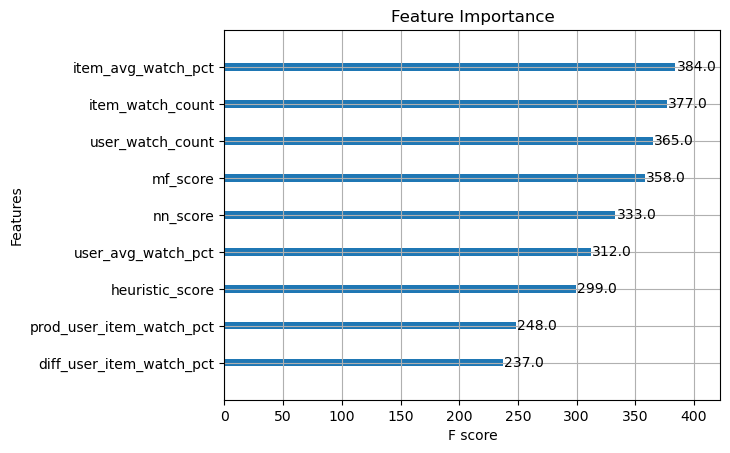

C:\Users\nikza\AppData\Local\Temp\ipykernel_7156\3963967384.py:38: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, train_df_with_features[features])


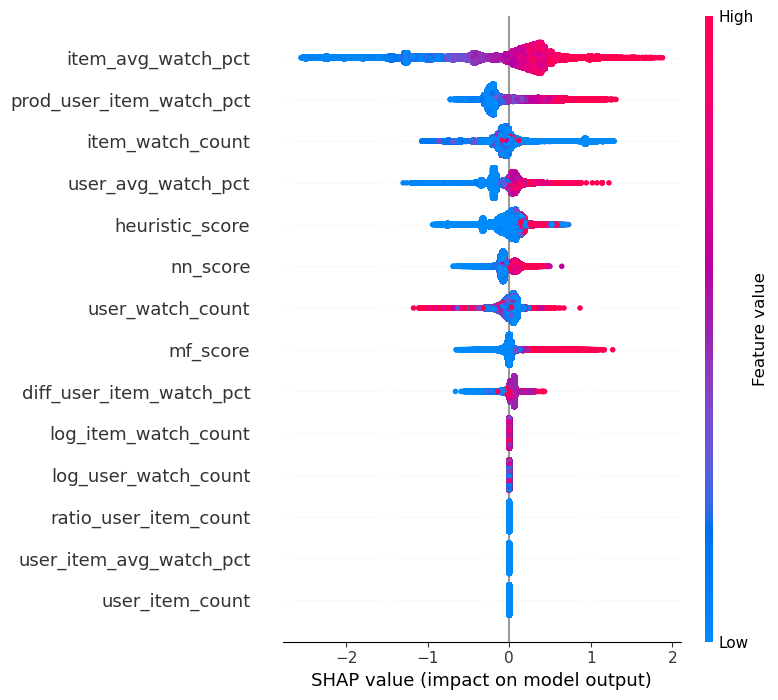

In [29]:
train_df_with_features['heuristic_score'] = train_df_with_features.apply(
    lambda row: heuristic_model.predict_score(row['user_id'], row['item_id']), axis=1)
train_df_with_features['mf_score'] = train_df_with_features.apply(
    lambda row: mf_model.predict_score(row['user_id'], row['item_id']), axis=1)
train_df_with_features['nn_score'] = train_df_with_features.apply(
    lambda row: nn_model.predict_score(row['user_id'], row['item_id']), axis=1)

# Определяем набор признаков
features = ['user_avg_watch_pct', 'user_watch_count',
            'item_avg_watch_pct', 'item_watch_count',
            'user_item_count', 'user_item_avg_watch_pct',
            'diff_user_item_watch_pct', 'ratio_user_item_count',
            'log_user_watch_count', 'log_item_watch_count',
            'prod_user_item_watch_pct',
            'heuristic_score', 'mf_score', 'nn_score']

dtrain = xgb.DMatrix(train_df_with_features[features], label=train_df_with_features['target'])
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'tree_method': 'gpu_hist' if is_gpu else 'auto',
    'seed': 42
}
num_round = 50
ranker_model = xgb.train(params, dtrain, num_boost_round=num_round)

xgb.plot_importance(ranker_model)
plt.title("Feature Importance")
plt.show()

explainer = shap.TreeExplainer(ranker_model)
shap_values = explainer.shap_values(train_df_with_features[features])
shap.summary_plot(shap_values, train_df_with_features[features])

## Выводы
Финальный ранкер на XGBoost был обучен на сформированных признаках и скорах трёх моделей первого уровня.

Анализ важности признаков показал, что комбинация пользовательских, айтем-признаков и особенно их взаимодействия даёт наибольший вклад в итоговый скор.

SHAP-значения помогли интерпретировать влияние каждого признака и проверить отсутствие явных утечек (никакая одна фича не доминировала с кратно большей важностью).

Таким образом, итоговый ранкер успешно агрегирует результаты кандидатов от разных моделей и учитывает разнообразные фичи, что повышает итоговую точность рекомендаций.


### 4 Этап. Инференс лучшего ранкера (max 3 балла)

Теперь мы хотим построить рекомендации "на завтра", для этого нам нужно:

1. Обучить модели первого уровня на всех (train+test) данных (0.5 балла)
2. Для каждой модели первого уровня для каждого пользователя сгененировать N кандидатов (0.5 балла)
3. "Склеить" всех кандидатов для каждого пользователя (дубли выкинуть), посчитать скоры от всех моделей (0.5 балла)
4. Собрать фичи для ваших кандидатов (теперь можем считать признаки на всех данных) (0.5 балла)
5. Проскорить всех кандидатов бустингом и оставить k лучших (0.5 балла)
6. Посчитать разнообразие(Diversity) и построить график от Diversity(k) (0.5 балла)


Все гиперпараметры (N, k) определяете только Вы!

Epoch 1/3, Loss: 0.2203
Epoch 2/3, Loss: 0.2076
Epoch 3/3, Loss: 0.1947
Рекомендации для пользователя 718866: [12719, 9465, 5249, 485, 10133, 3731, 4470, 15787, 16504, 12684]
Diversity@10: 0.0002
Прошло 334.0030860900879 минут. k = 1 отработало. diversity = 0.000202
Прошло 645.0042433738708 минут. k = 2 отработало. diversity = 0.0002005
Прошло 981.0019288063049 минут. k = 3 отработало. diversity = 0.0002025
Прошло 1290.0050148963928 минут. k = 4 отработало. diversity = 0.0002
Прошло 1597.0046291351318 минут. k = 5 отработало. diversity = 0.0002015
Прошло 1931.0142731666565 минут. k = 6 отработало. diversity = 0.0002015
Прошло 2270.003086090088 минут. k = 7 отработало. diversity = 0.0001985
Прошло 2560.0100297927856 минут. k = 8 отработало. diversity = 0.0002
Прошло 2871.0135016441345 минут. k = 9 отработало. diversity = 0.0002
Прошло 3168.0135016441345 минут. k = 10 отработало. diversity = 0.0002
Прошло 3466.0088725090027 минут. k = 11 отработало. diversity = 0.0001795
Прошло 3803.0027

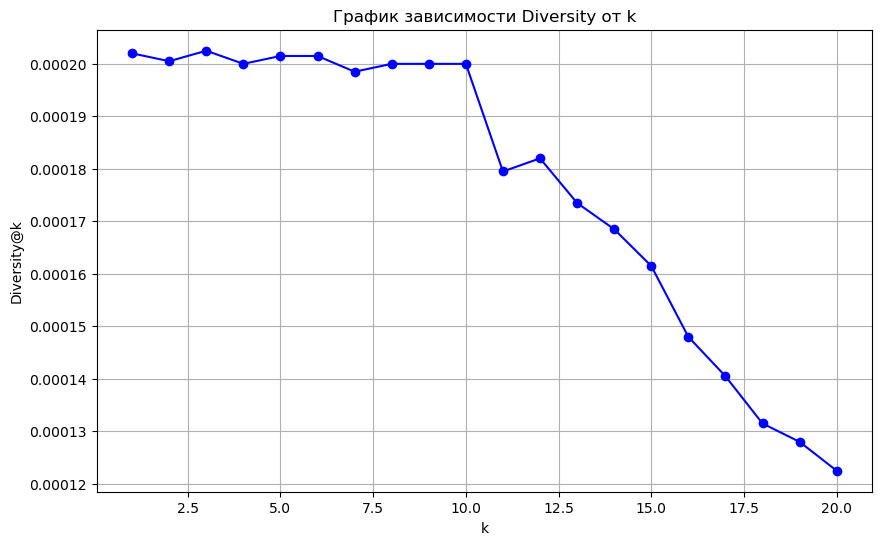

In [30]:
full_data = pd.concat([train_df, test_df]).sort_values('last_watch_dt')

heuristic_model_full = HeuristicModel(default_score=0)
heuristic_model_full.fit(full_data)

mf_model_full = MatrixFactorizationModel(n_factors=20, default_score=0)
mf_model_full.fit(full_data)

nn_model_full = NeuralNetworkWrapper(default_score=0, embedding_dim=20, epochs=3, batch_size=1024, lr=0.001)
nn_model_full.fit(full_data)

N = 50  # число кандидатов от каждой модели

def get_candidates_for_user(user_id):
    candidates = set()
    rec1 = heuristic_model_full.recommend(user_id, top_k=N)
    rec2 = mf_model_full.recommend(user_id, top_k=N)
    rec3 = nn_model_full.recommend(user_id, top_k=N)
    candidates.update(rec1)
    candidates.update(rec2)
    candidates.update(rec3)
    return list(candidates)

users_test = test_df['user_id'].unique()

user_candidates = {}
for user in users_test:
    user_candidates[user] = get_candidates_for_user(user)

# Склеиваем всех кандидатов. Создаем df с кандидатами и их скорами от моделей
candidates_list = []
for user, items in user_candidates.items():
    for item in items:
        score_h = heuristic_model_full.predict_score(user, item)
        score_mf = mf_model_full.predict_score(user, item)
        score_nn = nn_model_full.predict_score(user, item)
        candidates_list.append({
            'user_id': user,
            'item_id': item,
            'heuristic_score': score_h,
            'mf_score': score_mf,
            'nn_score': score_nn
        })

candidates_df = pd.DataFrame(candidates_list)

# Генерация фичей
cutoff_full = full_data['last_watch_dt'].max() + pd.Timedelta(days=1)
candidates_df = compute_features(candidates_df.copy(), cutoff_full, full_data)

# Финальный ранкер
dtest = xgb.DMatrix(candidates_df[features])
candidates_df['ranker_score'] = ranker_model.predict(dtest)

# Для каждого пользователя оставляем топ-10 рекомендаций
k = 10
final_recommendations = {}
for user in candidates_df['user_id'].unique():
    user_df = candidates_df[candidates_df['user_id'] == user].sort_values('ranker_score', ascending=False)
    final_recommendations[user] = user_df.head(k)['item_id'].tolist()

# Пример рекомендации для пользователя
first_user = list(final_recommendations.keys())[0]
print(f"Рекомендации для пользователя {first_user}: {final_recommendations[first_user]}")

all_recommended_items = [item for recs in final_recommendations.values() for item in recs]
diversity = len(set(all_recommended_items)) / (k * len(final_recommendations))
print(f"Diversity@{k}: {diversity}")

# Diversity(k) для k от 1 до 20
ks = range(1, 21)
diversity_list = []
unique_users = candidates_df['user_id'].unique()
time0 = time.time()
for k_val in ks:
    temp_rec = []
    for user in unique_users:
        user_df = candidates_df[candidates_df['user_id'] == user].sort_values('ranker_score', ascending=False)
        recs = user_df.head(k_val)['item_id'].tolist()
        temp_rec.extend(recs)
    diversity_k = len(set(temp_rec)) / (k_val * len(unique_users))
    diversity_list.append(diversity_k)
    print(f"Прошло {(time.time() - time0)/60} минут. k = {k_val} отработало. diversity = {diversity_k}")

plt.figure(figsize=(8, 5))
plt.plot(ks, diversity_list, marker='o')
plt.xlabel('k')
plt.ylabel('Diversity@k')
plt.title('Зависимость Diversity от k')
plt.grid(True)
plt.show()


## Выводы
Модели первого уровня (эвристика, SVD, нейросеть) были дообучены на всём датасете (train + test) и сгенерировали для каждого пользователя по 50 кандидатов.

Финальный ранкер XGBoost пересчитал итоговые скоры для объединённого списка кандидатов, и мы взяли Top-k самых релевантных айтемов для каждого пользователя.

Diversity@k показал, что при увеличении k набор рекомендаций становится более “однообразным” (снижается доля уникальных айтемов), однако на малых k сохраняется приемлемое разнообразие.